In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib.colors import ListedColormap

IS_DARK = True
theme, cs = rp.mpl_setup(IS_DARK)

In [2]:
df = pd.read_feather('logs/12345.feather')
df.head()

,comp_ind,e_form,group_num,volume_ratio,lattice_type,wyckoff_letters,total_dof,i,comp,group_symbol
0,0,-5.328977,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc
1,1,-5.155964,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc
2,2,-5.348216,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc
3,3,-5.455560,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc
4,4,-5.431657,126,1.17021,tetragonal,e_b_e,2,1,Bi2Ce4O4,P4/nnc


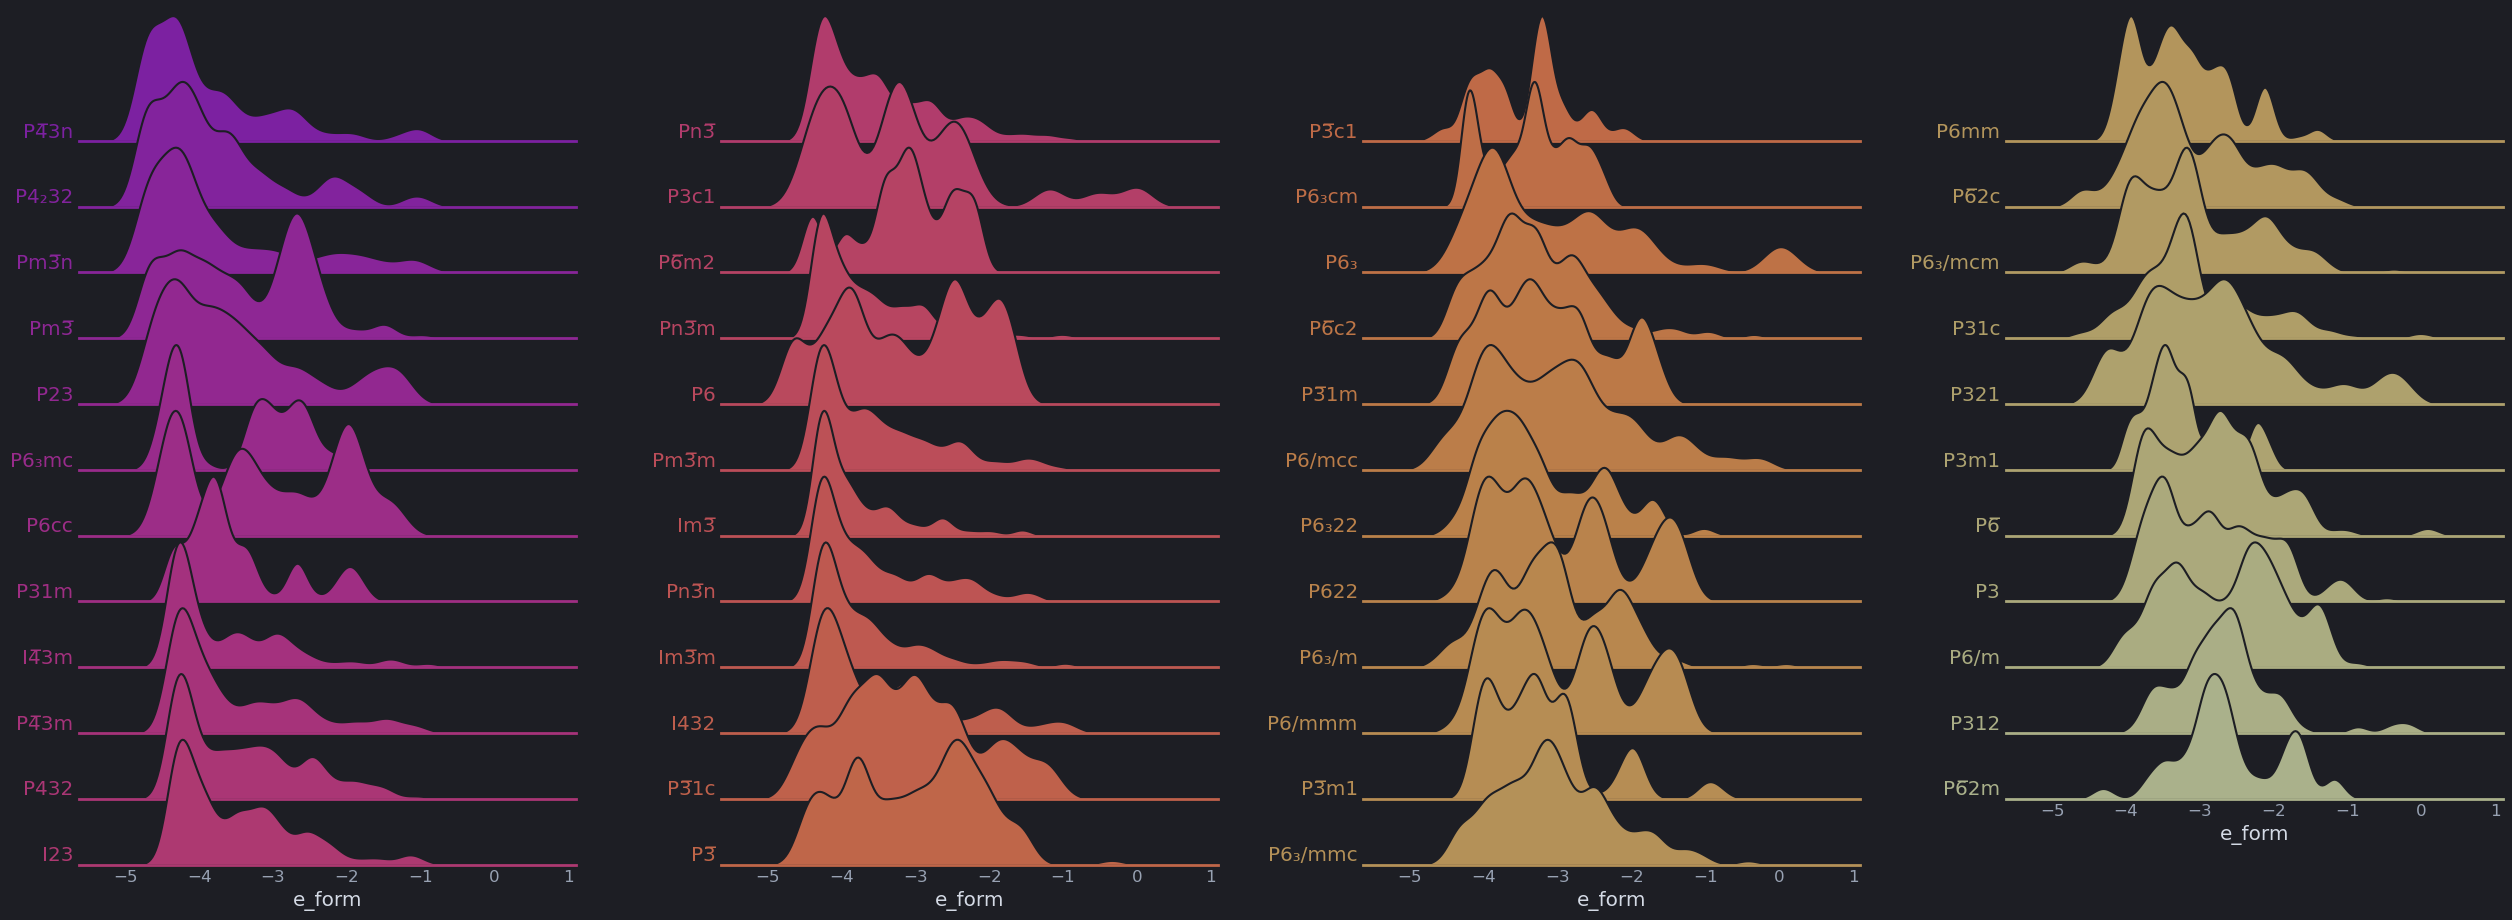

In [3]:
from baysic.viz import ridge_plot

ridge_plot(df.query('comp == "La2Pm6" and (lattice_type == "cubic" or lattice_type == "hexagonal")'), 'group_symbol', 'e_form', height=5)

In [129]:
import torch
def make_Xy(df):
    X = torch.tensor(np.hstack([
        df[['comp']].rank(method='dense').astype(int),
        df[['group_num']].rank(method='dense').astype(int),
    ])).long()
    y = torch.tensor(df['e_form'].values).float()

    return (X, y,
    sorted(set(df['comp'])),
    sorted(set(df['group_num'])))

test_comps = sorted([
    'La2Pm6', 'La2Tb6', 'Pb8Rh4', 'La10Pb6Zn2'
])
X, y, comps, groups = make_Xy(df.query('comp in @test_comps and comp_ind < 15 and (lattice_type == "cubic" or lattice_type == "hexagonal")'))
print(len(set(X[:, 0].cpu().numpy())), 'comps')
print(len(set(X[:, 1].cpu().numpy())), 'groups')
print(X[::len(X)//5])
X.shape, y.shape

4 comps
56 groups
tensor([[ 3, 51],
        [ 3, 23],
        [ 4, 21],
        [ 2,  6],
        [ 2, 47]])


(torch.Size([2640, 2]), torch.Size([2640]))

In [52]:
import torch
import pyro
import pyro.nn as nn
import pyro.distributions as dist
from pyro.contrib import gp
from baysic.utils import debug_shapes
from pyro import poutine
import logging

logging.basicConfig(level=logging.INFO, force=True)

In [106]:
from pyro.ops.indexing import Vindex
class Encoder(nn.PyroModule):
    def __init__(
        self,
        X: torch.LongTensor,
        y: torch.FloatTensor,
        num_clusters: int = 3,
        latent_dim: int = 32):
        super().__init__()
        self.num_compositions, self.num_groups = X.max(axis=0).values + 1
        self.num_clusters = num_clusters
        self.latent_dim = latent_dim
        self.group_latents = nn.PyroSample(
            dist.MultivariateNormal(
                torch.zeros(latent_dim),
                torch.eye(latent_dim)
            ).expand([self.num_groups, self.num_clusters]).to_event(2))

    def forward(self, X, cluster_i=None):
        if cluster_i is None:
            print('Filling in random indices!')
            cluster_i = torch.randint_like(X[..., [0]], 3)
        X_comps, X_groups = X[..., 0], X[..., 1]
        cluster_i = cluster_i[..., 0]

        group_mu = self.group_latents
        debug_shapes('group_mu', 'X_groups', 'cluster_i')

        data_pts = Vindex(group_mu)[..., X_groups, cluster_i, :]
        debug_shapes('data_pts')
        return data_pts

enc = Encoder(X, y)
print(enc(X, torch.arange(3)[:, None, None]).shape, '\n')

torch.Size([3, 2640, 32]) 



In [107]:
enc.group_latents.shape

torch.Size([57, 3, 32])

  0%|          | 0/200 [00:00<?, ?it/s]/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'obs_1', 'obs_2'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/pyro/util.py:515: RuntimeWarning: at model site "encoder.group_latents", possibly invalid dependency.
  Expected site "encoder.group_latents" to precede sites "cluster_i"
  to avoid breaking independence of plates "data"
  warnings.warn(
/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/pyro/util.py:515: RuntimeWarning: at model site "obs_0", possibly invalid dependency.
  Expected site "obs_0" to precede sites "cluster_i"
  to avoid breaking independence of plates "data"
  warnings.warn(
/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/pyro/util.py:515: RuntimeWarning: at model site "obs_1", possibly invalid dependency.
  Expected site

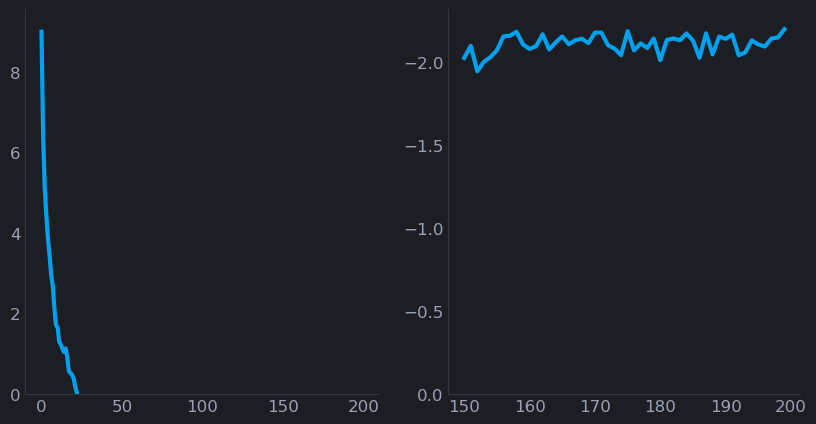

In [168]:

class BaysicGPR(nn.PyroModule):
    def __init__(self, X, y, num_clusters: int = 3, latent_dim: int = 2):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_clusters = num_clusters
        self.X = X
        self.y = y
        self.encoder = Encoder(X, y, num_clusters=num_clusters, latent_dim=latent_dim)
        self.kernel = gp.kernels.RBF(
            input_dim=latent_dim,
            variance=torch.tensor(1.0),
            lengthscale=torch.tensor(1.0),
        )
        self.Xu = nn.PyroSample(dist.MultivariateNormal(torch.zeros(latent_dim), torch.eye(latent_dim)).expand((20,)))
        self.likelihood = gp.likelihoods.Gaussian(variance=torch.tensor(0.1))
        self.gpr = gp.models.VariationalSparseGP(
            torch.randn(X.size(0), latent_dim),
            y,
            self.kernel,
            self.Xu,
            self.likelihood,
            num_data=X.size(0),
        )
        self.cluster_i = nn.PyroSample(dist.Categorical(logits=torch.ones(num_clusters)))

    def forward(self, y=None):
        with pyro.plate('data', self.X.size(0), dim=-2):
            X = self.X
            clusters = self.cluster_i
            debug_shapes('X', 'clusters')

        X_latent = self.encoder(X, clusters)
        if X_latent.ndim == 2:
            X_latent = X_latent.unsqueeze(0)
        debug_shapes('X_latent')

        for i in range(X_latent.size(-3)):
            try:
                self.gpr.X = X_latent[i]
                full_cov = False
                mean, var = self.gpr(X_latent[i], full_cov=full_cov)
                if not full_cov:
                    cov = torch.diag(var)
                debug_shapes('mean', 'cov')
                pyro.sample(f'obs_{i}', dist.MultivariateNormal(mean, cov), obs=y)
            except torch.linalg.LinAlgError as e:
                N = self.gpr.X.size(0)
                M = self.gpr.Xu.size(0)

                # TODO: cache these calculations to get faster inference

                Kuu = self.gpr.kernel(self.gpr.Xu).contiguous()
                Kuu.view(-1)[:: M + 1] += self.gpr.jitter  # add jitter to the diagonal
                Luu = torch.linalg.cholesky(Kuu)

                Kuf = self.gpr.kernel(self.gpr.Xu, self.gpr.X)

                W = torch.linalg.solve_triangular(Luu, Kuf, upper=False)
                D = self.gpr.noise.expand(N)

                W_Dinv = W / D
                K = W_Dinv.matmul(W.t()).contiguous()
                K.view(-1)[:: M + 1] += 1  # add identity matrix to K
                L = torch.linalg.cholesky(K)
                print(e)
                raise e

from tqdm import tqdm
from pyro.infer import autoguide
import matplotlib.pyplot as plt

torch.manual_seed(234)

num_epochs = 200

pyro.get_param_store().clear()

gpr = BaysicGPR(X, y, latent_dim=2)

lr1 = 5e-2
lr2 = 1e-2
lrd = (lr2 / lr1) ** (1 / num_epochs)
gpr_opt = pyro.optim.clipped_adam.ClippedAdam(gpr.parameters(), lr=lr1, lrd=lrd)
loss_fn = pyro.infer.TraceEnum_ELBO(max_plate_nesting=2).differentiable_loss

guide = autoguide.AutoGuideList(gpr)
guide.append(autoguide.AutoDiscreteParallel(poutine.block(gpr, expose=['cluster_i'])))
guide.append(autoguide.AutoDiagonalNormal(poutine.block(gpr, hide=['cluster_i'])))


losses = []
with tqdm(total=num_epochs) as bar:
    for i in range(num_epochs):
        gpr.zero_grad()
        gp_loss = loss_fn(gpr, guide)
        gp_loss.backward()
        gpr_opt.step()

        loss = gp_loss.item() / y.numel()
        losses.append(loss)
        bar.set_description('{:.3f}'.format(loss))
        bar.update()

def loss_plot(losses):
    """Smart plot for loss curves."""
    losses = np.asanyarray(losses)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    if losses.min() < 0:
        fig.set_title('{:.3f}'.format(losses.min()))
        losses += losses.min()

    ax1.plot(losses)
    inds = np.arange(len(losses))[-len(losses)//4:]
    ax2.plot(inds, losses[inds])
    ax1.set_ylim(0, None)
    ax2.set_ylim(0, ax2.get_ylim()[1] * 1.2)

loss_plot(losses)

In [170]:
predictive = pyro.infer.Predictive(gpr, guide=guide, num_samples=100)
samples = predictive()

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        v = v.float()
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

summary(samples)

{'cluster_i': {'mean': tensor([[0.9700],
          [0.9500],
          [1.0200],
          ...,
          [1.0900],
          [0.8800],
          [0.9900]]),
  'std': tensor([[0.8221],
          [0.8333],
          [0.7652],
          ...,
          [0.7926],
          [0.8442],
          [0.8102]]),
  '5%': tensor([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]),
  '95%': tensor([[2.],
          [2.],
          [2.],
          ...,
          [2.],
          [2.],
          [2.]])},
 'encoder.group_latents': {'mean': tensor([[[[[ 8.0828e-03,  5.6176e-03],
             [ 1.5811e-03, -1.9176e-03],
             [-9.0936e-03, -6.4413e-03]],
  
            [[-2.5961e-03,  7.0060e-03],
             [ 2.2522e-03,  2.6991e-03],
             [ 1.9067e-03,  1.1102e-03]],
  
            [[-1.3043e-02, -3.1519e-03],
             [-1.8927e-03,  1.7625e-02],
             [ 1.4411e-03, -7.9576e-03]],
  
            [[-2.5005e-03,  8.0531e-04],
   

In [172]:
pts.shape

(100, 57, 3, 2)

In [174]:
from baysic.utils import to_pretty_name
pts = samples['encoder.group_latents'].squeeze().cpu().numpy()
gdf = pd.DataFrame(pts.mean(axis=-2)[:, 1:, :].reshape(-1, 2), index=pd.MultiIndex.from_product(
    [range(100), groups], names=['sample', 'group']), columns=['x', 'y']).reset_index()

gdf['symbol'] = to_pretty_name(gdf['group'])
gdf.head()

,sample,group,x,y,symbol
0,0,143,-0.053358,-0.004691,P3
1,0,147,0.018075,-0.070728,P3̅
2,0,149,0.084551,0.041910,P312
3,0,150,0.048583,-0.040706,P321
4,0,156,0.087059,0.081631,P3m1


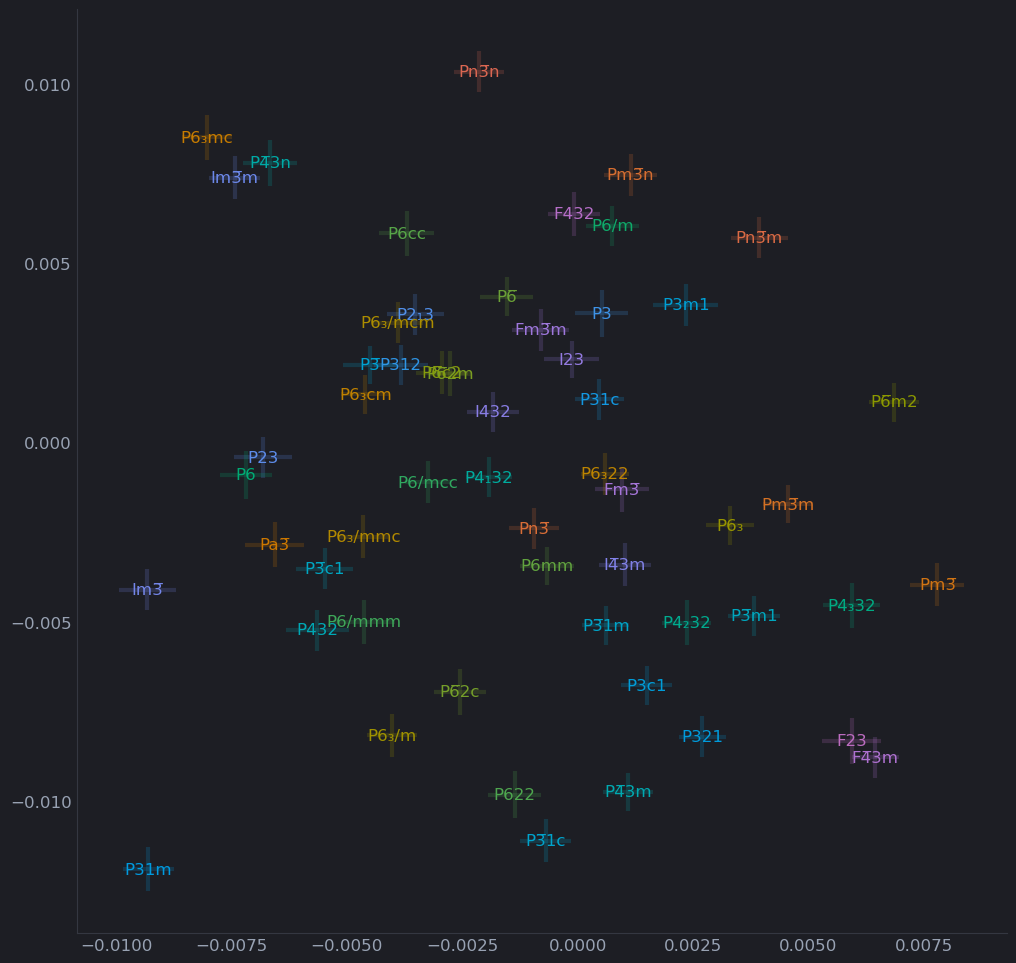

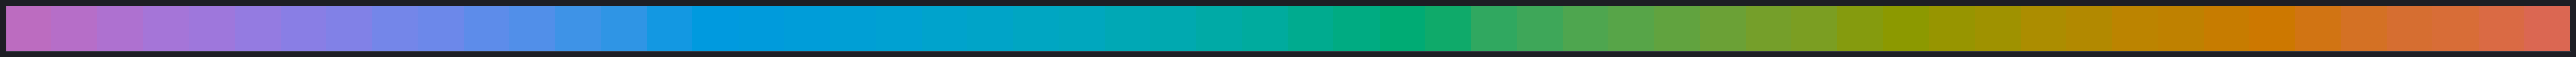

In [183]:
fig, ax = plt.subplots(figsize=(12, 12))

group_colors = sns.color_palette('rho_iso_spectra', len(groups))

for (group, subset), color in zip(gdf.groupby('symbol'), group_colors):
    x_mu, y_mu = subset[['x', 'y']].values.mean(axis=0)
    x_sigma, y_sigma = subset[['x', 'y']].values.std(axis=0) * 0.01
    ax.text(x_mu, y_mu, group, fontdict=dict(color=color), ha='center', va='center')
    ax.errorbar(x_mu, y_mu, xerr=x_sigma, yerr=y_sigma, alpha=0.2, color=color)

sns.palplot(group_colors)

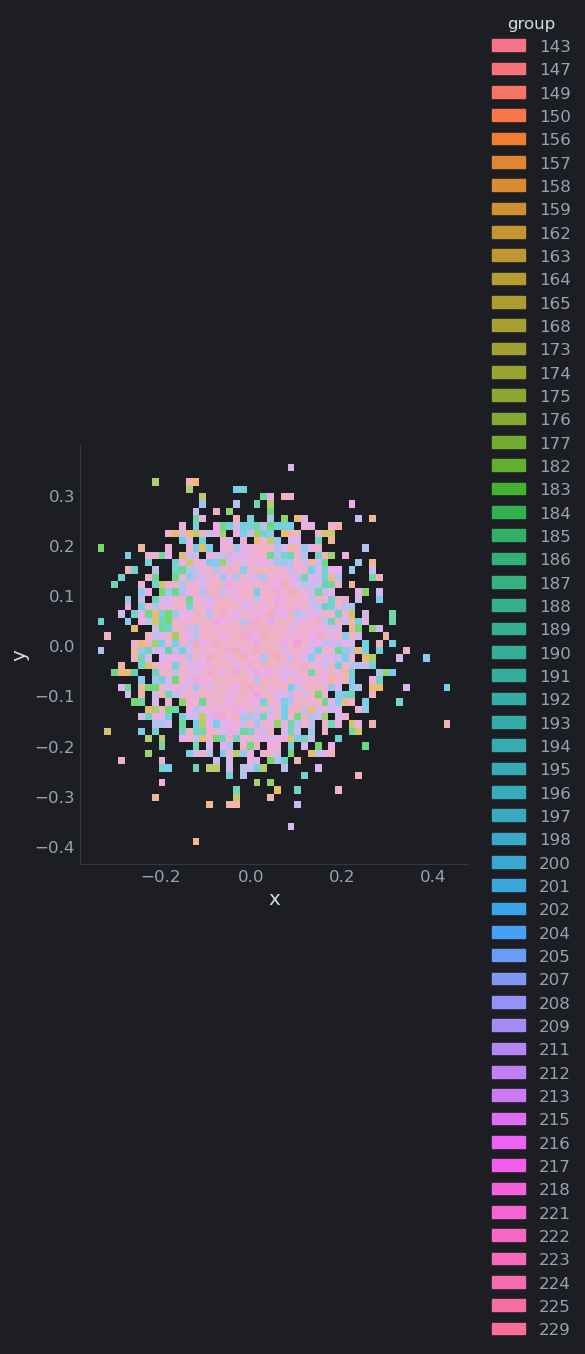

In [144]:
sns.displot(gdf, x='x', y='y', hue='group')

In [ ]:
# from pyro import poutine
# trace = poutine.trace(poutine.enum(gpr, first_available_dim=-5)).get_trace()
# trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
# print(trace.format_shapes())

In [ ]:
# from pyro.infer import NUTS, MCMC

# hmc_kernel = NUTS(gpr, max_tree_depth=5)
# mcmc = MCMC(hmc_kernel, num_samples=200)
# mcmc.run()

In [ ]:
from tqdm import tqdm
from pyro.infer import autoguide
import matplotlib.pyplot as plt

torch.manual_seed(234)

num_epochs = 2

pyro.get_param_store().clear()

gpr = BaysicGPR(X, y, latent_dim=2)

lr1 = 5e-2
lr2 = 1e-2
lrd = (lr2 / lr1) ** (1 / num_epochs)
gpr_opt = pyro.optim.clipped_adam.ClippedAdam(gpr.parameters(), lr=lr1, lrd=lrd)
loss_fn = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1).differentiable_loss

guide = autoguide.AutoGuideList(gpr)
guide.append(autoguide.AutoDiscreteParallel(poutine.block(gpr, expose=['cluster_i'])))
guide.append(autoguide.AutoDelta(poutine.block(gpr, hide=['cluster_i'])))


losses = []
with tqdm(total=num_epochs) as bar:
    for i in range(num_epochs):
        gpr.zero_grad()
        gp_loss = loss_fn(gpr, guide)
        gp_loss.backward()
        gpr_opt.step()

        loss = gp_loss.item() / y.numel()
        losses.append(loss)
        bar.set_description('{:.3f}'.format(loss))
        bar.update()


def loss_plot(losses):
    """Smart plot for loss curves."""
    losses = np.asanyarray(losses)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(losses)
    inds = np.arange(len(losses))[-len(losses)//4:]
    ax2.plot(inds, losses[inds])
    ax1.set_ylim(0, None)
    ax2.set_ylim(0, ax2.get_ylim()[1] * 1.2)

loss_plot(losses)

In [ ]:
dict(pyro.get_param_store())